<font size = "5"> **Day 3: [Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization](../MLSTEM2024.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/gduscher/MLSTEM2024//main/Day3/6_Analyse_EELS.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day3/6_Analyse_EELS.ipynb)


# Analysis of Electron Energy-Loss Spectra
Lecturer: Gerd Duscher

part of the workshop of 

<font size = "5"> **[Machine Learning in Scanning Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day3: Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**



## Content
We use widgets to form a dashboard that allows to combine the analysis of low_loss and core-loss data comprehensively.


## Load important packages

### Check Installed Packages


In [3]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install --upgrade git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
# ------------------------------
print('done')

installing pyTEMlib
done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [10]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np

import sys
sys.path.insert(0, '../../pyTEMlib')

%load_ext autoreload
%autoreload 2

# additional package 
import ipywidgets as ipyw
from scipy.optimize import leastsq, curve_fit  ## fitting routine of scipy

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import eels_tools  
import pyTEMlib.info_widget
import pyTEMlib.eels_dialog
import pyTEMlib.peak_dialog
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2024.05.0


## Load and plot a spectrum

In [20]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    if not os.path.exists('./STO_Stack_10.dm3'):
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/1EELS Acquire (low-loss).dm3
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/1EELS Acquire (high-loss).dm3
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/AL-DFoffset0.00.dm3
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/EELS_STO.dm3
        
infoWidget = pyTEMlib.info_widget.EELSWidget()

AppLayout(children=(Tab(children=(GridspecLayout(children=(Dropdown(description='directory:', layout=Layout(gr…

In [16]:
infoWidget.core_loss.dataset.metadata

{'experiment': {'single_exposure_time': 3.0,
  'exposure_time': 63.0,
  'number_of_frames': 21,
  'collection_angle': 33.0,
  'convergence_angle': 30.0,
  'acceleration_voltage': 60000.0,
  'flux_ppm': 0.0,
  'count_conversion': 1,
  'beam_current': 0,
  'eff_beta': 24.856444995721606},
 'edges': {'fit_area': {'fit_start': 102.5, 'fit_end': 609.5},
  '0': {'z': 5,
   'symmetry': 'K1',
   'element': 'B',
   'onset': 188.0,
   'end_exclude': 238.0,
   'start_exclude': 183.0,
   'all_edges': {'K1': {'onset': 188.0}},
   'chemical_shift': 0.0,
   'areal_density': 19436.213143872435,
   'original_onset': 188.0,
   'data': array([4.63485362e-09, 4.59607924e-09, 4.55730486e-09, ...,
          1.37107109e-10, 1.36853981e-10, 1.36600853e-10]),
   'X_section_type': 'XRPA',
   'X_section_source': 'pyTEMlib'},
  '1': {'z': 7,
   'symmetry': 'K1',
   'element': 'N',
   'onset': 401.6,
   'end_exclude': 451.6,
   'start_exclude': 396.6,
   'all_edges': {'K1': {'onset': 401.6}},
   'chemical_shift': 

## peakfit

###### from pyTEMlib import peak_dialog

In [15]:
spectrum = infoWidget.selected_dataset
peakFitWidget = pyTEMlib.peak_dialog.PeakFitWidget({'core_loss': spectrum})

AppLayout(children=(GridspecLayout(children=(Button(description='Fit Area', layout=Layout(grid_area='widget001…

In [18]:
infoWidget.selected_dataset.metadata


{'experiment': {'single_exposure_time': 3.0,
  'exposure_time': 63.0,
  'number_of_frames': 21,
  'collection_angle': 50.0,
  'convergence_angle': 30.0,
  'acceleration_voltage': 60000.0,
  'flux_ppm': 34706.602478027344,
  'count_conversion': 1,
  'beam_current': 0,
  'eff_beta': 45.09593300550967},
 'zero_loss': {'shifted': array([1.0174319])},
 'edges': {'fit_area': {'fit_start': 102.5, 'fit_end': 609.5},
  '0': {'z': 5,
   'symmetry': 'K1',
   'element': 'B',
   'onset': 188.0,
   'end_exclude': 238.0,
   'start_exclude': 183.0,
   'all_edges': {'K1': {'onset': 188.0}},
   'chemical_shift': 0.0,
   'areal_density': 1731512397628.7842,
   'original_onset': 188.0,
   'data': array([7.19944622e-09, 7.13176526e-09, 7.06408430e-09, ...,
          1.64923910e-10, 1.64654230e-10, 1.64384551e-10]),
   'X_section_type': 'XRPA',
   'X_section_source': 'pyTEMlib'},
  '1': {'z': 7,
   'symmetry': 'K1',
   'element': 'N',
   'onset': 401.6,
   'end_exclude': 451.6,
   'start_exclude': 396.6,
  

In [19]:
for peak in spectrum.metadata['peak_fit']['peaks'].values():
    print (f"{peak['position']:.1f}, {peak['width']:.2f}, {peak['amplitude']:.0f}")

201.7, 10.65, 19233
196.6, 3.25, 60303
213.2, 4.35, 16275
406.5, 11.94, 2783
414.1, 7.03, 4800
609.1, 1.17, 1088
499.2, 1.32, 1274
407.1, 3.23, 5544
194.8, 8.19, -29998


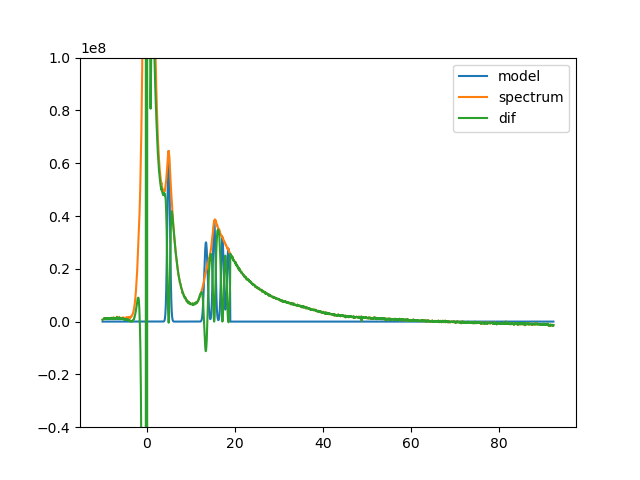

In [33]:
plt.close('all')
plt.figure()
plt.plot(peakFitWidget.energy_scale,peakFitWidget.peak_model, label='model')
plt.plot(peakFitWidget.energy_scale,peakFitWidget.dataset, label='spectrum')
plt.plot(peakFitWidget.energy_scale, peakFitWidget.dataset-peakFitWidget.peak_model-resolution_functions, label='dif')
plt.ylim(-4e7,1e8)
plt.legend()

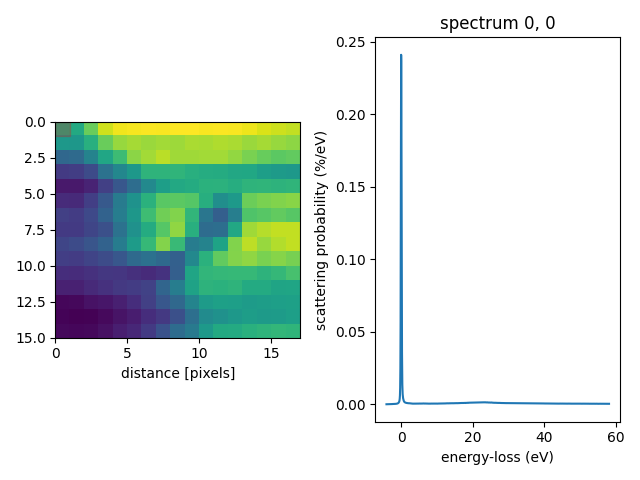

In [6]:
eels_dataset.metadata['low_loss'].update(resolution_functions.metadata['low_loss'])
shifted_dataset = eels_tools.shift_on_same_scale(eels_dataset)
view = shifted_dataset.plot()

c:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 2000.
  warnings.warn(errors[info][0], RuntimeWarning)


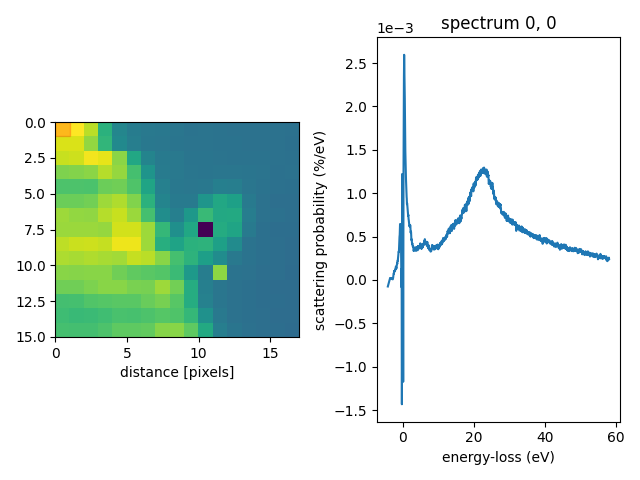

In [7]:
shifted_resolution_functions = eels_tools.get_resolution_functions(shifted_dataset, zero_loss_fit_width=.9)
dif = shifted_dataset - shifted_resolution_functions
view = dif.plot()

In [8]:
datasets = fileWidget.datasets
#datasets['energy_corrected'] = shifted_dataset
#datasets['energy_corrected_resolution_function'] = shifted_resolution_functions

infoWidget= interactive_eels.InfoWidget(datasets)

c:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


ValueError: array of sample points is empty

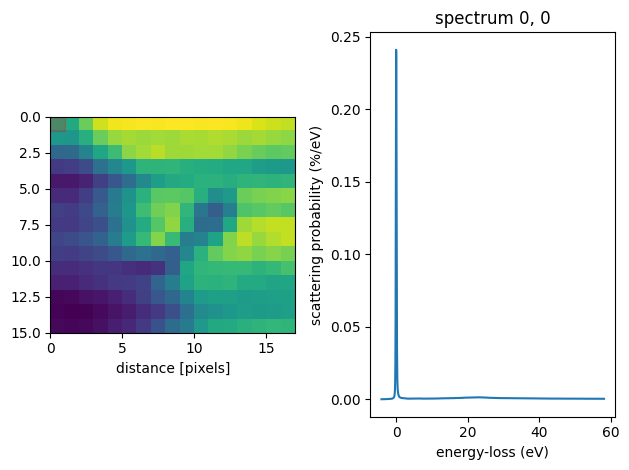

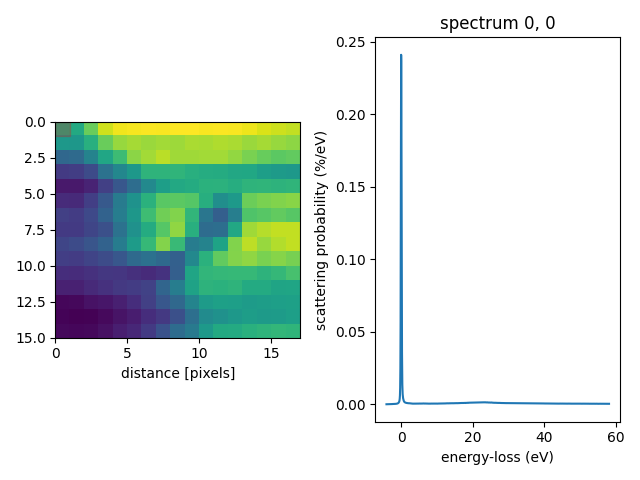

In [15]:
v = shifted_dataset.plot()


In [40]:
FWHM, energy_shift = eels_tools.fix_energy_scale(eels_dataset)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {energy_shift:.3f} eV')
eels_dataset.energy_loss -= energy_shift

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)
print(zero_loss)
plt.figure()
plt.plot(eels_dataset.energy_loss, eels_dataset, label='spectrum')
plt.plot(eels_dataset.energy_loss, zero_loss, label = 'zero-loss')
plt.plot(eels_dataset.energy_loss, np.array(eels_dataset)-zero_loss , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.3f} %')
print(f'Sum of Spectrum: {Itotal:.3f} %')
print (f'thickness [IMFP]: {tmfp:.5f}')

ValueError: object of too small depth for desired array

## Summary

In this notebook we show a convenient way to 
- Combine Low-Loss and COre-Loss Spectra and SPectra Images
- Quantify EELS spectra
- Get a noise free representation of a spectrum
- Determine positions of features
- 
The advantages of EELS is the derivation of these values spatially resolved.

